# Detecting emotions in Spanish lyrics songs: Vanilla SNN 

## Imports

In [8]:
import pandas as pd, numpy as np
import brian2 as b2
from brian2 import *
import matplotlib.pyplot as plt

# Vectorizadores
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split

# descarga las stopwords en español y guardalas en una lista
from nltk.corpus import stopwords
import string 
from nltk.tokenize import word_tokenize
stopwords = set(stopwords.words('spanish'))


# Grafica en formato retina
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')

WARNING    /var/folders/d9/9kxdpj_1093dfyt04_xwd8v80000gn/T/ipykernel_16704/2243671251.py:19: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('retina')
 [py.warnings]


## Functions

In [9]:
def vectorize_text(train_data, test_data, min_df, ngrams, stop_words_lang):
    # Vectorizar texto
    vectorizer = TfidfVectorizer(min_df=min_df, 
                                ngram_range=ngrams, 
                                stop_words=stop_words_lang)
    tfidf_train = vectorizer.fit_transform(train_data).toarray()
    tfidf_test = [vectorizer.transform(subset).toarray() for subset in test_data]
    
    return vectorizer, tfidf_train, tfidf_test

In [46]:
def lif_sdtp_vanilla(n_features, tfidf_matrix):
    # Configuración inicial de Brian2
    start_scope()

    # Parámetros STDP y neuronales
    sigma = 0.3
    taupre = 5*ms
    taupost = 8*ms
    wmax = 1.2
    wmin = -0.5
    Apre = 0.4*sigma
    Apost = -0.2*sigma
    tau = 10*ms
    vr = 0*volt
    vt = 1.5*mV

    eqs = '''
    dv/dt = -v/tau : volt (unless refractory)
    '''

    # Inicialización de pesos
    S_initial = np.random.uniform(low=0, high=0.1, size=(1, n_features))

    # Proceso de simulación para cada documento
    for document_vector in tfidf_matrix:
        G = NeuronGroup(1, eqs, threshold='v>vt', reset='v=vr', refractory=1.5*ms, method='linear')
        P = PoissonGroup(n_features, rates=document_vector*Hz)
        
        S = Synapses(P, G,
                    '''
                    w : 1
                    dapre/dt = -apre/taupre : 1 (event-driven)
                    dapost/dt = -apost/taupost : 1 (event-driven)
                    ''',
                    on_pre='''
                    v_post += w*mV
                    apre += Apre
                    w = clip(w+apost, wmin, wmax)
                    ''',
                    on_post='''
                    apost += Apost
                    w = clip(w+apre, wmin, wmax)
                    ''')

        S.connect()
        S.w = S_initial
        
        M = StateMonitor(G, 'v', record=True)
        spikemon_in = SpikeMonitor(P)
        spikemon_out = SpikeMonitor(G)
        
        run(100*ms)  # Ajusta la duración de la simulación según sea necesario

        # Opcional: Actualizar S_initial con los pesos aprendidos para el siguiente documento
        S_initial = S.w[:]
    
    return S, M, spikemon_in, spikemon_out

In [47]:
def normalize_tfidf_vectors(tfidf_matrix):
    """
    Normaliza los vectores TF-IDF para que estén en una escala adecuada para
    ser utilizados como tasas de disparo en una red de neuronas de Poisson.
    """
    tfidf_matrix = np.array(tfidf_matrix)
    normalized = (tfidf_matrix - np.min(tfidf_matrix)) / (np.max(tfidf_matrix) - np.min(tfidf_matrix)) * 255
    return normalized

In [11]:
def plot_spikes(M_spikes, M):
    # Visualización
    figure(figsize=(12, 6))
    subplot(121)
    plot(M_spikes.t/ms, M_spikes.i, '.k')
    xlim(0, 600)
    xlabel('Tiempo (ms)')
    ylabel('Índice de neurona')

    subplot(122)
    plot(M.t/ms, M.u[0]/mV)
    xlabel('Tiempo (ms)')
    ylabel('Potencial de membrana (mV)')

    show()

In [27]:
def plot_sample_distribution(categories, sample_values, colors, title):
    plt.figure(figsize=(10, 6))  # Ajusta el tamaño del gráfico
    bars = plt.bar(categories, sample_values, color=colors)
    plt.xlabel('Class')
    plt.ylabel('Number of samples')
    plt.title(title)
    
    # Añade etiquetas dentro de las barras
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval + 0.5, yval, ha='center', va='bottom')
    
    plt.tight_layout()  # Asegura que todo el contenido se muestre bien
    plt.show()

## Implementation

### Exploring data

In [13]:
data_path = '../Data/Spanish_songs_lyrics.csv'
data = pd.read_csv(data_path)

data.head()

,fragmento,genero,emocion
0,En un día de estos en que suelo pensar:,Pop,S
1,"""Hoy va a ser el día menos pensado""",Pop,S
2,"Nos hemos cruzado, has decidido mirar",Pop,P
3,A los ojitos azules que ahora van a tu lado,Pop,P
4,Desde el momento en el que te conocí,Pop,P


In [14]:
data.shape

(5957, 3)

In [15]:
data.emocion.value_counts()

emocion
N    2211
P    2140
S    1606
Name: count, dtype: int64

In [18]:
# Divide las canciones en X_train, y_train, X_test y y_test con un 80/20 split
X_train, X_test, y_train, y_test = train_test_split(data['fragmento'], 
                                                    data['emocion'], 
                                                    test_size=0.2, 
                                                    random_state=42)

In [23]:
y_train.value_counts()

emocion
N    1783
P    1688
S    1294
Name: count, dtype: int64

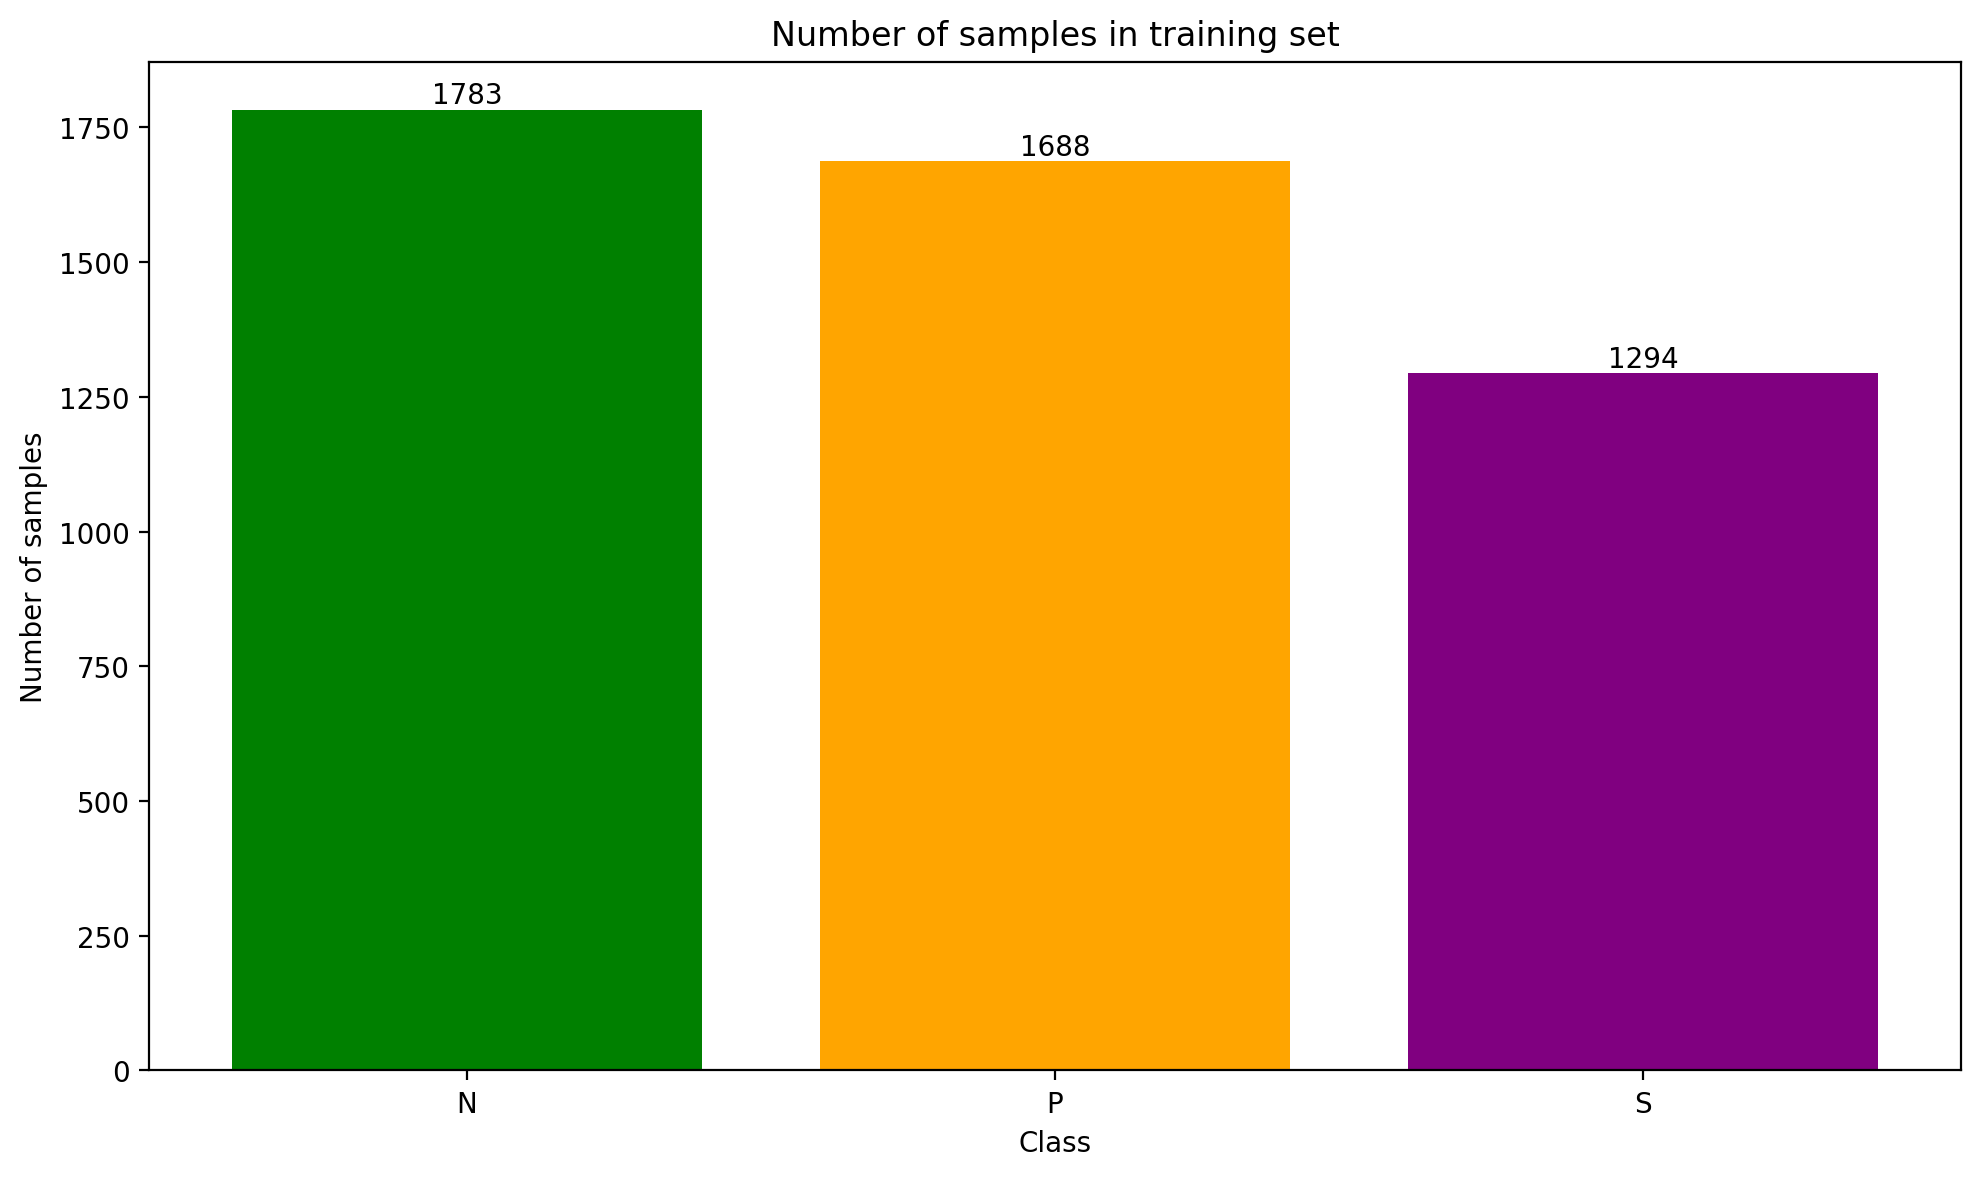

In [29]:
categories = ['N', 'P', 'S']
colors = ['green', 'orange', 'purple']
n_trainig_samples = [y_train.value_counts()[0], y_train.value_counts()[1], y_train.value_counts()[2]]
plot_sample_distribution(categories=categories, 
                         sample_values=n_trainig_samples, 
                         colors=colors, 
                         title='Number of samples in training set')

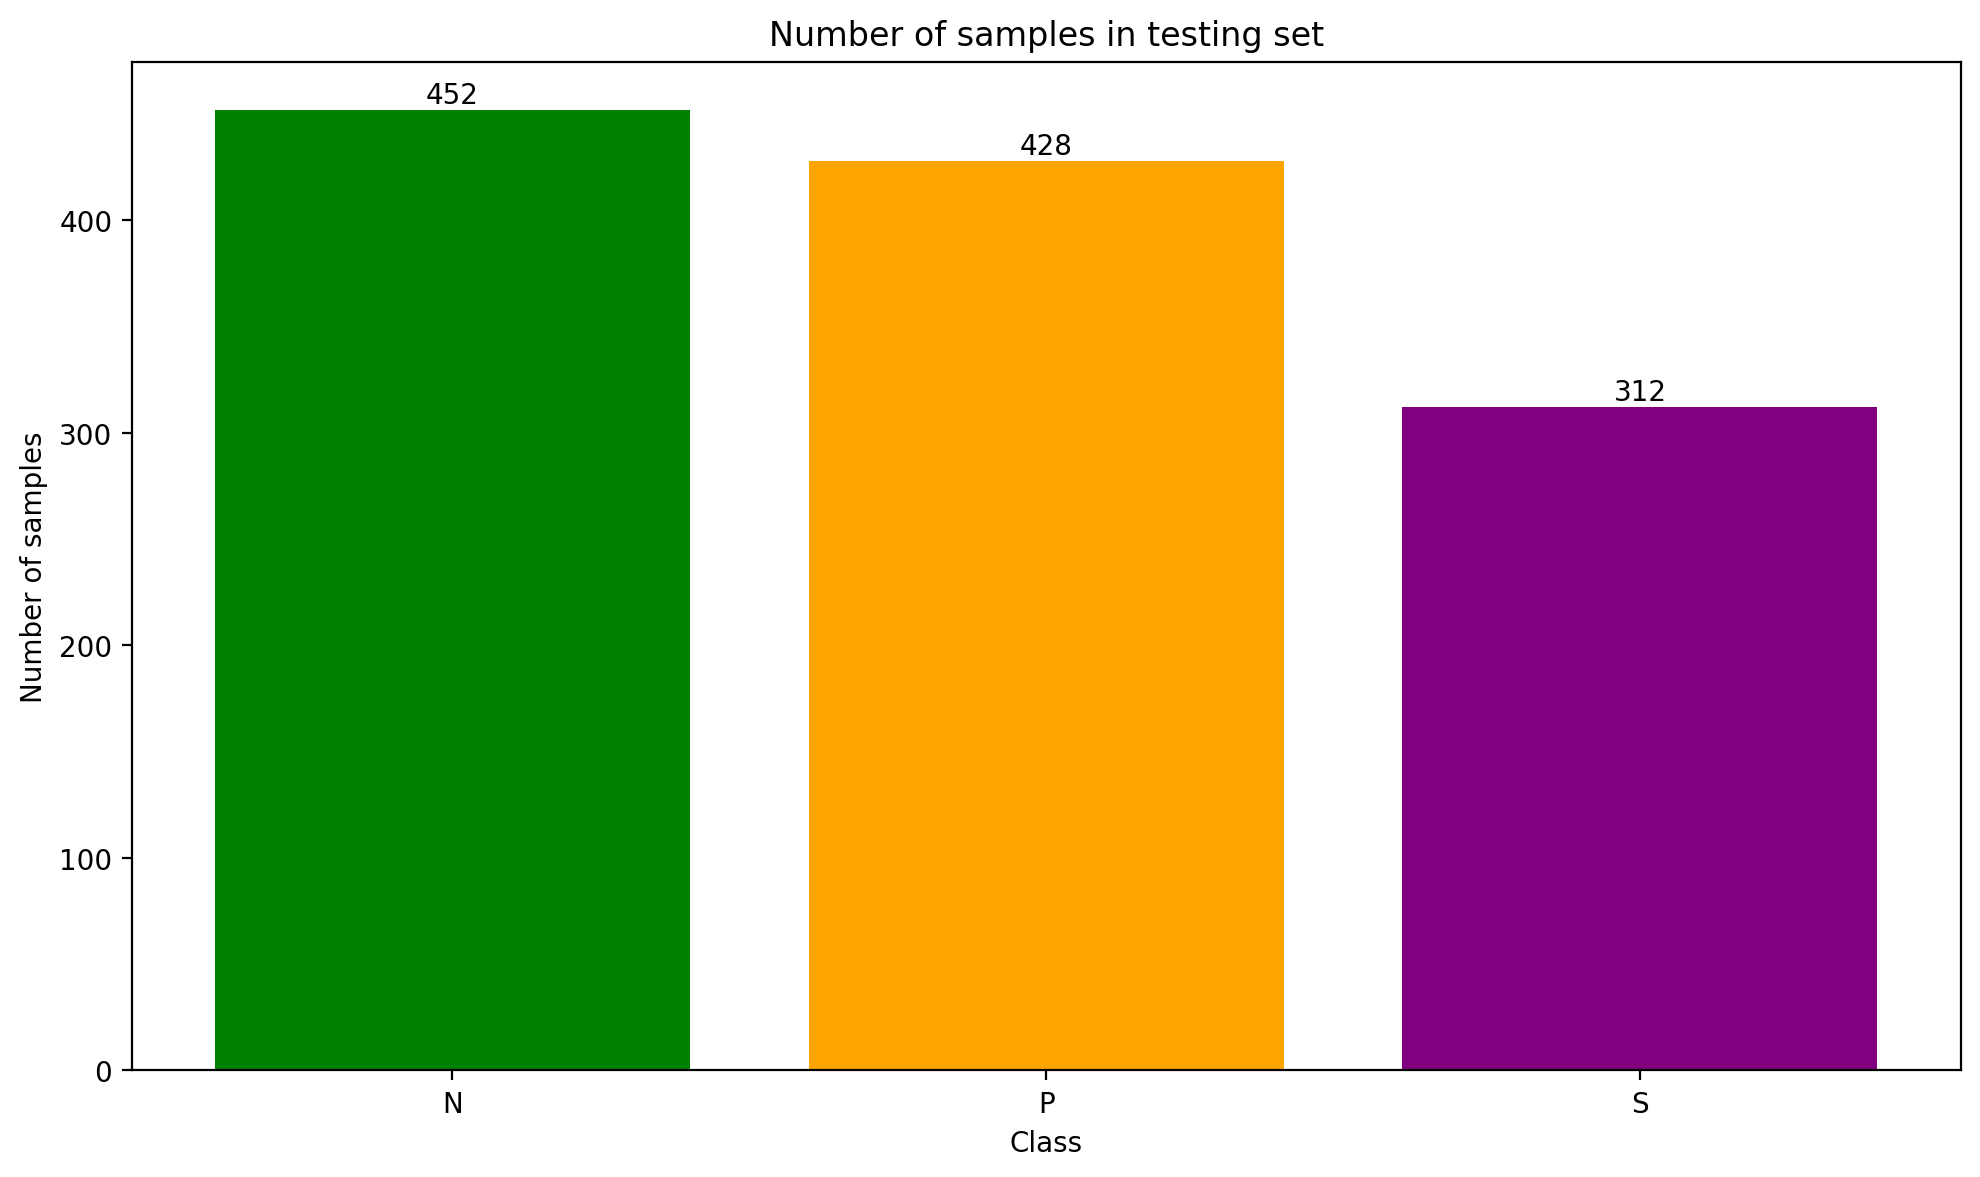

In [30]:
n_testing_samples = [y_test.value_counts()[0], y_test.value_counts()[1], y_test.value_counts()[2]]
plot_sample_distribution(categories=categories, 
                         sample_values=n_testing_samples, 
                         colors=colors, 
                         title='Number of samples in testing set')

### Vectorizing the data

In [31]:
stop_words_esp = list(stopwords)

In [43]:
# Obtener los indices de los valores de cada etiqueta en y_train
y_train_N = y_train[y_train == 'N'].index
y_train_P = y_train[y_train == 'P'].index
y_train_S = y_train[y_train == 'S'].index

# Obtener los indices de los valores de cada etiqueta en y_test
y_test_N = y_test[y_test == 'N'].index
y_test_P = y_test[y_test == 'P'].index
y_test_S = y_test[y_test == 'S'].index

In [44]:
# Obtener los valores de cada etiqueta basandome en los indices de y_train_n
X_train_N = X_train[y_train_N]
X_train_P = X_train[y_train_P]
X_train_S = X_train[y_train_S]

# Obtener los valores de cada etiqueta basandome en los indices de y_test_n
X_test_N = X_test[y_test_N]
X_test_P = X_test[y_test_P]
X_test_S = X_test[y_test_S]

In [71]:
n_normalized, p_normalized, s_normalized = [], [], []
for i in range(3):
    if i == 0:
        vectorizer_train_n, tfidf_train_n, tfidf_test_n = vectorize_text(train_data=X_train,
                                                                test_data=[X_test_N],
                                                                min_df=3,
                                                                ngrams=(1, 1),
                                                                stop_words_lang=stop_words_esp)
        for tfidf in tfidf_train_n:
            n_normalized.append(normalize_tfidf_vectors(tfidf))
    elif i == 1:
        vectorizer_train_p, tfidf_train_p, tfidf_test_p = vectorize_text(train_data=X_train,
                                                                test_data=[X_test_P],
                                                                min_df=3,
                                                                ngrams=(1, 1),
                                                                stop_words_lang=stop_words_esp)
        for tfidf in tfidf_train_p:
            p_normalized.append(normalize_tfidf_vectors(tfidf))
    elif i == 2:
        vectorizer_train_s, tfidf_train_s, tfidf_test_s = vectorize_text(train_data=X_train,
                                                                test_data=[X_test_S],
                                                                min_df=3,
                                                                ngrams=(1, 1),
                                                                stop_words_lang=stop_words_esp)
        for tfidf in tfidf_train_s:
            s_normalized.append(normalize_tfidf_vectors(tfidf))

WARNING    /var/folders/d9/9kxdpj_1093dfyt04_xwd8v80000gn/T/ipykernel_16704/3083546973.py:7: RuntimeWarning: invalid value encountered in true_divide
  normalized = (tfidf_matrix - np.min(tfidf_matrix)) / (np.max(tfidf_matrix) - np.min(tfidf_matrix)) * 255
 [py.warnings]


### SNN: Class N

In [72]:
S_n, M_n, spikemon_in_n, spikemon_out_n = lif_sdtp_vanilla(n_features=tfidf_train_n.shape[1], 
                                                           tfidf_matrix=n_normalized)

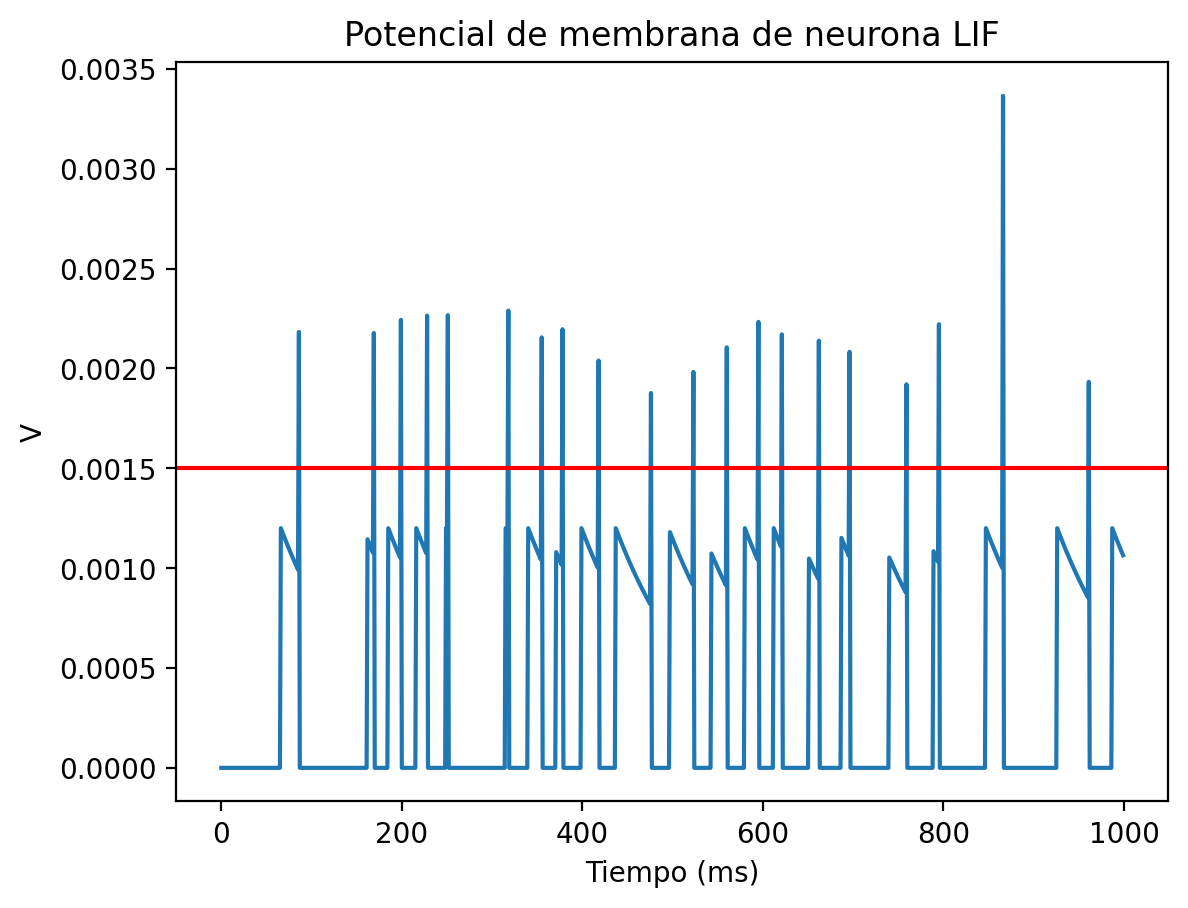

In [73]:
# Visualise first 1000 time steps
plot(M_n.v[0][:])
axhline(1.5/1000, color='r')
title('Potencial de membrana de neurona LIF')
xlabel('Tiempo (ms)')
ylabel('V')
show()

In [74]:
print('No of spikes from input: {}'.format(spikemon_in_n.num_spikes))
print('No of spikes from output: {}'.format(spikemon_out_n.num_spikes))

No of spikes from input: 56
No of spikes from output: 20


### SNN: Class P

In [75]:
S_p, M_p, spikemon_in_p, spikemon_out_p = lif_sdtp_vanilla(n_features=tfidf_train_p.shape[1], 
                                                           tfidf_matrix=p_normalized)

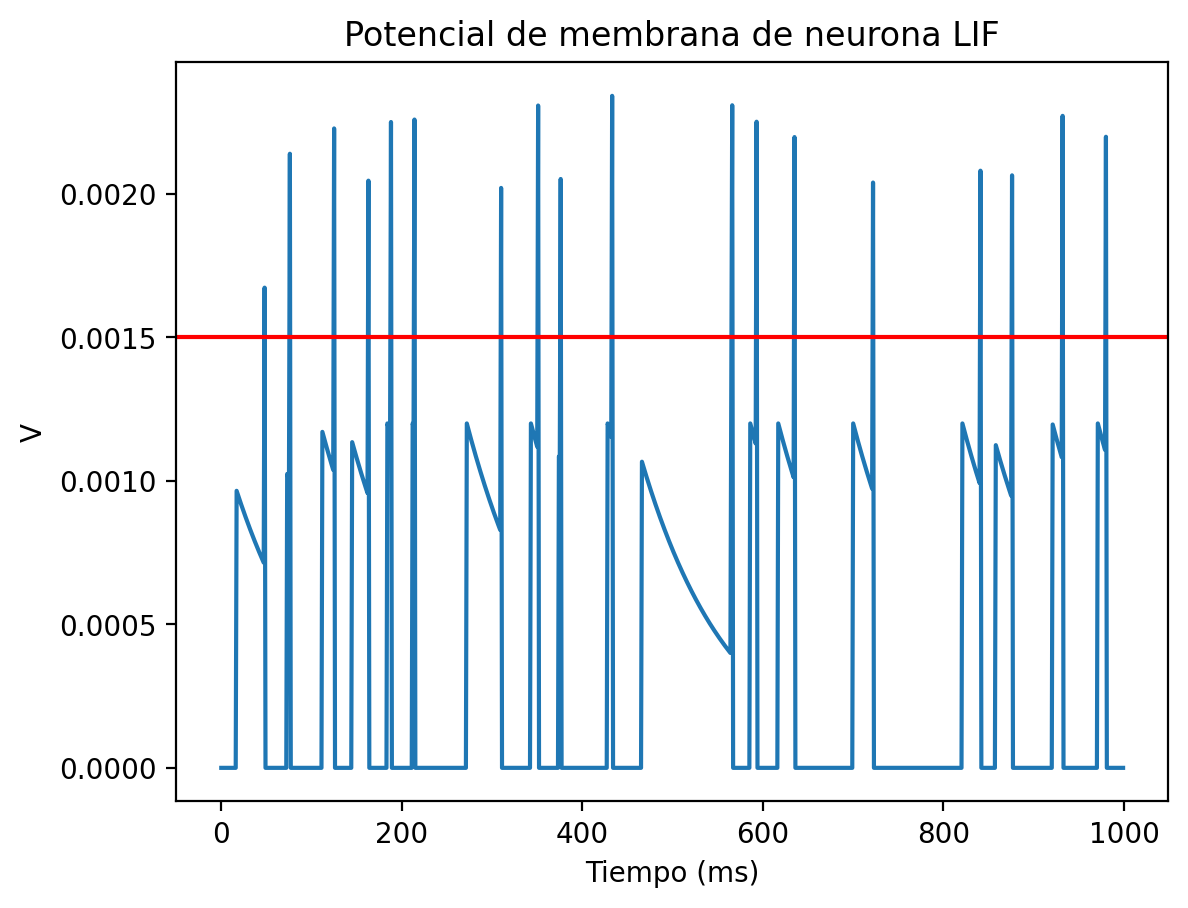

In [76]:
# Visualise first 1000 time steps
plot(M_p.v[0][:])
axhline(1.5/1000, color='r')
title('Potencial de membrana de neurona LIF')
xlabel('Tiempo (ms)')
ylabel('V')
show()

In [77]:
print('No of spikes from input: {}'.format(spikemon_in_p.num_spikes))
print('No of spikes from output: {}'.format(spikemon_out_p.num_spikes))

No of spikes from input: 50
No of spikes from output: 18


### SNN: Class S

In [78]:
S_s, M_s, spikemon_in_s, spikemon_out_s = lif_sdtp_vanilla(n_features=tfidf_train_s.shape[1], 
                                                           tfidf_matrix=s_normalized)

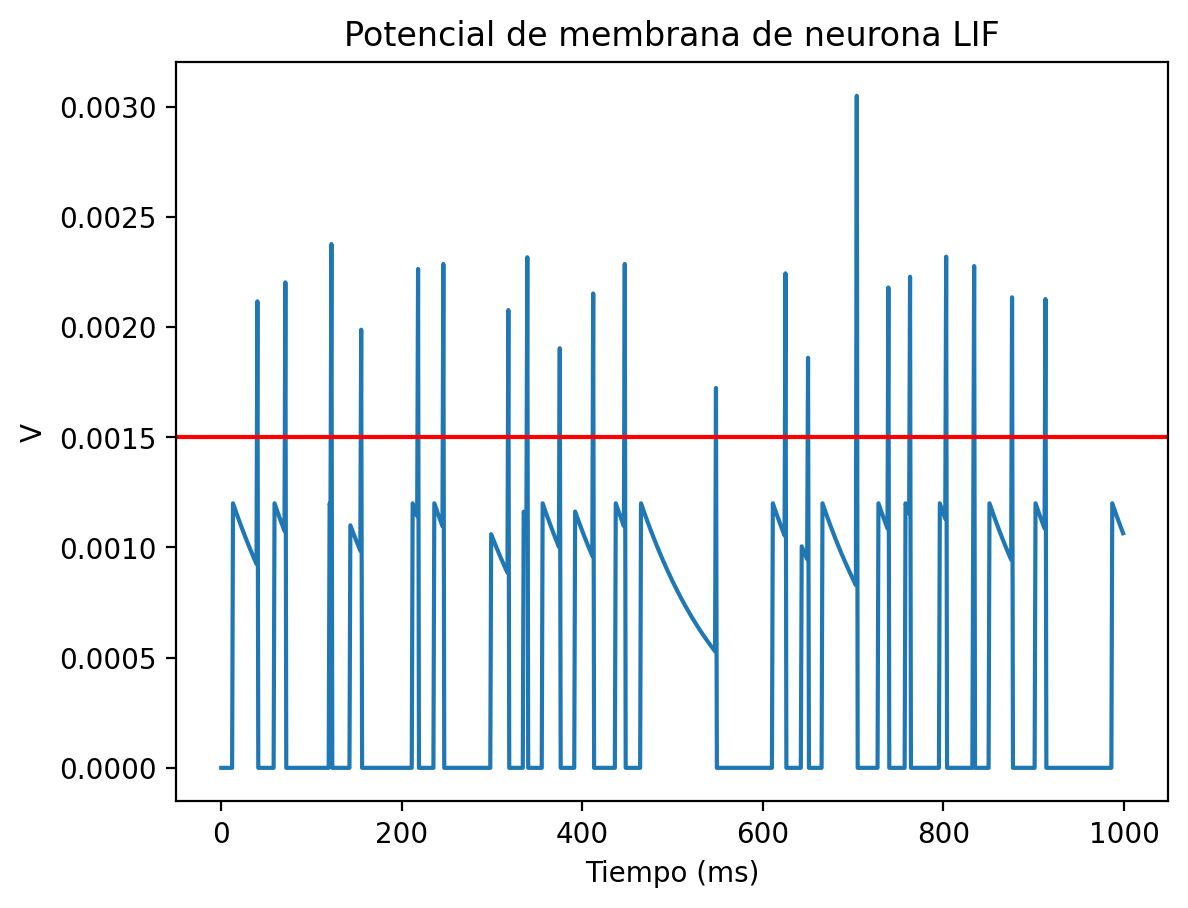

In [79]:
# Visualise first 1000 time steps
plot(M_s.v[0][:])
axhline(1.5/1000, color='r')
title('Potencial de membrana de neurona LIF')
xlabel('Tiempo (ms)')
ylabel('V')
show()

In [80]:
print('No of spikes from input: {}'.format(spikemon_in_s.num_spikes))
print('No of spikes from output: {}'.format(spikemon_out_s.num_spikes))

No of spikes from input: 58
No of spikes from output: 21


### Testing

In [117]:
def test_phase(tfidf_test, n_features, S_trained, num_spikes_trained):
    
    start_scope()

    # Parámetros STDP y neuronales
    sigma = 0.3
    taupre = 5*ms
    taupost = 8*ms
    wmax = 1.2
    wmin = -0.5
    Apre = 0.4*sigma
    Apost = -0.2*sigma
    tau = 10*ms
    vr = 0*volt
    vt = 1.5*mV

    eqs = '''
    dv/dt = -v/tau : volt (unless refractory)
    '''

    predicciones = []

    # Usamos las mismas ecuaciones neuronales y parámetros STDP (sin actualizaciones de peso)
    for document_vector in tfidf_test:

        G_test = NeuronGroup(1, eqs, threshold='v>vt', reset='v=vr', refractory=1.5*ms, method='linear')
        P_test = PoissonGroup(n_features, rates=document_vector*Hz)

        S_test = Synapses(P_test, G_test,
                        '''
                        w : 1
                        dapre/dt = -apre/taupre : 1 (event-driven)
                        dapost/dt = -apost/taupost : 1 (event-driven)
                        ''',
                        on_pre='''
                        v_post += w*mV
                        apre += Apre
                        ''',
                        on_post='''
                        apost += Apost
                        ''')

        S_test.connect()
        S_test.w = S_trained.w  # Cargar los pesos entrenados

        M_test = StateMonitor(G_test, 'v', record=True)
        test_spikemon = SpikeMonitor(G_test)
        
        run(100*ms)  # Ajustar según sea necesario

        predicciones.append(round(test_spikemon.num_spikes / num_spikes_trained.num_spikes, 4))

    return predicciones

In [118]:
test_norm = []
vectorizer_test, tfidf_train, tfidf_test = vectorize_text(train_data=X_train,
                                                                test_data=[X_test],
                                                                min_df=3,
                                                                ngrams=(1, 1),
                                                                stop_words_lang=stop_words_esp)
for tfidf in tfidf_test:
    test_norm.append(normalize_tfidf_vectors(tfidf))

In [119]:
S_trained = [S_n, S_p, S_s]
spikemon_out_obtained = [spikemon_out_n, spikemon_out_p, spikemon_out_s]
n_features = tfidf_train.shape[1]

In [120]:
for i, weigths in enumerate(S_trained):
    if i == 0:
        predicciones_n = test_phase(tfidf_test=test_norm[0], 
                                    n_features=n_features, 
                                    S_trained=weigths, 
                                    num_spikes_trained=spikemon_out_obtained[i])
    elif i == 1:
        predicciones_p = test_phase(tfidf_test=test_norm[0], 
                                    n_features=n_features, 
                                    S_trained=weigths, 
                                    num_spikes_trained=spikemon_out_obtained[i])
    elif i == 2:
        predicciones_s = test_phase(tfidf_test=test_norm[0], 
                                    n_features=n_features, 
                                    S_trained=weigths, 
                                    num_spikes_trained=spikemon_out_obtained[i])

In [122]:
test_predicts = np.column_stack((predicciones_n, predicciones_p, predicciones_s))
test_predicts

array([[0.9   , 1.0556, 1.    ],
       [0.55  , 0.7222, 0.4762],
       [0.85  , 0.8889, 0.8571],
       ...,
       [0.55  , 0.5   , 0.381 ],
       [0.6   , 0.5   , 0.4286],
       [0.85  , 0.8889, 0.6667]])

In [123]:
result = []
for row in test_predicts:
    max_index = np.argmax(row)
    
    if max_index == 0:
        result.append('N')
    elif max_index == 1:
        result.append('P')
    elif max_index == 2:
        result.append('S')

In [128]:
# Calcula f1, precision, recall, classification_report (macro avg) para dev y test
from sklearn.metrics import f1_score, precision_score, recall_score, classification_report, accuracy_score, hamming_loss
import numpy as np
def evaluacion(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred, normalize=True, sample_weight=None)
    h_loss = hamming_loss(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='macro')
    precision = precision_score(y_true, y_pred, average='macro')
    recall = recall_score(y_true, y_pred, average='macro')
    report = classification_report(y_true, y_pred, target_names=classes)
    return accuracy, h_loss, f1, precision, recall, report

In [129]:
classes = ['N', 'P', 'S']
accuracy, h_loss, f1, precision, recall, report = evaluacion(y_test.tolist(), result)


In [ ]:
print(f'Accuracy: {accuracy}')
print(f'Hamming Loss: {h_loss}')
print(f'F1-score: {f1}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'Classification report:\n {report}')

Accuracy: 0.32802013422818793
Hamming Loss: 0.6719798657718121
F1-score: 0.2839640403876464
Precision: 0.29643821940333565
Recall: 0.30348622306483525
Classification report:               precision    recall  f1-score   support

           N       0.30      0.24      0.26       428
           P       0.36      0.57      0.44       452
           S       0.23      0.11      0.14       312

    accuracy                           0.33      1192
   macro avg       0.30      0.30      0.28      1192
weighted avg       0.30      0.33      0.30      1192

